In [1]:
import pandas as pd
import json
import itertools
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import math
%matplotlib inline

### Leitura do arquivo

In [2]:
arquivo = open("teste-ab-export.json")
linhas = arquivo.readlines()
texto = "".join(linhas)
dados_fire = json.loads(texto)

### Análise do atributo logs

 Veja que log, que contém todos os dados, está pesadamente aninhado

In [3]:
for k,v in dados_fire["logs"].items():
    # print(k,v) # habilite para imprimir as chaves de mais alto nível
    for chave, valor in v.items():
        # print(chave, valor) # habilite para imprimir as chaves inferiores
        pass # desabilite quando reabilitar a linha de cima



### Convertendo para um dataframe

O pandas entende listas de dicionários que têm as mesmas chaves. O Firebase nos dá dicionários de dicionários de dicionários. 

Vamos precisar converter. Basta inserir todos os itens que estavam na chave "logs" em uma lista

In [4]:
lista_dicionarios = []

for k,v in dados_fire["logs"].items():
    lista_dicionarios.append(v)

        


A função `from_records` converte a lista de dicionários em um dataframe

In [5]:
dataframe = pd.DataFrame.from_records(lista_dicionarios)

Desta forma temos o dataframe. Observe que os eventos são dos seguintes tipos:

* *inicio* - quando um usuário inicia uma tarefa
* final - quando o usuário termina uma tarefa

Precisamos agrupar pelo `id` do usuário e depois subtrair o tempo inicial do final, para sabermos quanto tempo efetivamente levou aquela tarefa

In [6]:
dataframe

,tempo,tipo,user_id,versao
0,1478529174126,inicio,1208266147,A
1,1478529140905,inicio,1208266147,A
2,1478526724389,inicio,1528978230,B
3,1478519346204,inicio,2754007705,B
4,1478518887954,final,3534175994,B
5,1478529063083,inicio,609063334,A
6,1478536039947,inicio,1213412462,B
7,1478560865309,inicio,4152027044,B
8,1478519833845,inicio,2986003787,A
9,1478520725538,inicio,3899117471,B


### Convertendo para um DataFrame de delta_t

In [7]:
agrupado = dataframe.groupby(by=["user_id", "versao"])

In [8]:
users = set(dataframe.user_id) # We convert it to a set so that each user appear only once

In [9]:
users = list(users) 

In [10]:
resultados = []

for u in users:
    for versao in ["A", "B"]:
        if (u, versao) in agrupado.groups.keys(): # Check if a specific pair user/type of test happened
            grupo1 =  agrupado.get_group((u, versao))
            grupo1 = grupo1.sort_values(by="tempo") # Para evitar que inícios sem fim gerem tempos negativos
            
            if len(grupo1[grupo1.tipo=="final"])>= 1 and len(grupo1[grupo1.tipo=="inicio"]) >= 1:
                delta_t = grupo1[grupo1.tipo=="final"].iloc[-1].tempo - grupo1[grupo1.tipo=="inicio"].iloc[0].tempo
                resultados.append({"user_id":u, "delta_t":delta_t, "versao":versao})

In [11]:
grupo1.sort_values(by="tempo")

,tempo,tipo,user_id,versao
51,1478544828909,inicio,2696156667,B
59,1478544864747,inicio,2696156667,B
17,1478544900181,final,2696156667,B


In [12]:
dataframe_resumo = pd.DataFrame.from_records(resultados)

In [13]:
dataframe_resumo.delta_t/=1000 # Convertendo milissegundos em segundos

In [14]:
dataframe_resumo

,delta_t,user_id,versao
0,41.311,1561760900,A
1,13.297,116148368,A
2,24.232,2754007705,B
3,7.509,984025379,A
4,20.961,1585826857,A
5,75.802,1857098293,A
6,10.151,1528978230,B
7,6.957,1212005310,A
8,19.823,190964928,B
9,11.625,3237228231,A


# Teste de hipotese

In [23]:
tempos_A = list(dataframe_resumo[dataframe_resumo.versao=="A"].delta_t)
tempos_B = list(dataframe_resumo[dataframe_resumo.versao=="B"].delta_t)
tempos_ma= []
tempos_mb = []

print(tempos_B)

for i in tempos_A: #retira todo mundo que demorou mais de 2 minutos
    if i<= 120:
        tempos_ma.append(i)
for i in tempos_B:
    if i<= 120:
        tempos_mb.append(i)

tempos_A = list(tempos_ma)
tempos_B = list(tempos_mb)

print(tempos_B)

[24.231999999999999, 10.151, 19.823, 7450.1199999999999, 11.016, 12.221, 12.262, 627.94000000000005, 11.032, 71.272000000000006]
[24.231999999999999, 10.151, 19.823, 11.016, 12.221, 12.262, 11.032, 71.272000000000006]


(array([ 1.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0,  8, 16, 24, 32, 40, 48, 56, 64, 72]),
 <a list of 9 Patch objects>)

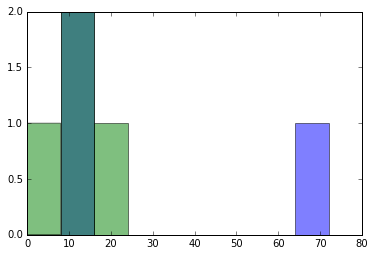

In [16]:
faixa =  np.arange(0,80,8)

plt.hist(tempos_B,alpha=0.5,bins =faixa)
plt.hist(tempos_A,alpha=0.5,bins =faixa)

In [17]:
tabela = pd.DataFrame([[np.mean(tempos_A),np.median(tempos_A),np.var(tempos_A)],[np.mean(tempos_B),np.median(tempos_B),np.var(tempos_B)]])
tabela.index = ["A","B"]
tabela.columns = ["media","mediana","variancia"]
tabela

,media,mediana,variancia
A,4868.6408,13.297,94335013.631656
B,1634.3408,71.272,8509715.899781


nossa hipotese é que o tempo medio de B é menor que o tempo medio de A (B<A), o contrario seria B>=A,assim:

hipótese nula: B>=A

hipótese alternativa: B<A

In [24]:
media_b = np.mean(tempos_B)
var_b = np.var(tempos_B)


media_a = np.mean(tempos_A)
var_a = np.var(tempos_A)


n = (len(tempos_A) + len(tempos_B) -2)
#variancia populacional desconhecida,A e B tem a mesma variancia.
var_c = ((var_a*(len(tempos_A)-1)) + (var_b*(len(tempos_B)-1)))/n


#média padronizada com o desvio padrão amostral.
Z = (media_b - media_a)/(math.sqrt(var_c*(1/len(tempos_A) + 1/len(tempos_B))))

#distribuição t-student com (n-1) graus de liberdade,unicaldal a esquerda.
valor_p =(1-scipy.stats.t.cdf(Z, df=n))
    
alfa = 0.05 #nivel de siginificancia de 5%

if valor_p<alfa:
    print('nos não podemos rejeitar a hipotese nula pois ',valor_p,'<',alfa,'(com grau confiança de 95%)')
else:
    print('podemos rejeitar a hipotese nula pois ',valor_p,'>',alfa,'(com grau confiança de 95%)')
         

podemos rejeitar a hipotese nula pois  0.532765664072 > 0.05 (com grau confiança de 95%)
